# Modelo Rosenzweig-MacArthur

Un modelo razonable para las poblaciones de presas y depredadores a través del tiempo, considerando su interacción, podría tener esta forma:

$\dot{x}=$ tasa de nacimiento - tasa de muertes no debidas a $ y $ - tasa de muertes por depredación

$\dot{y}=$ tasa de reproducción - tasa de mortalidad

Donde $ x $ representa la densidad de presas (número de presas por unidad de área), y $ y $ la densidad de depredadores (número de depredadores por unidad de área).

Un modelo cualquiera es una elección de cómo computar estas tasas, así lo abstrae el modelo de **Rosenzweig-McArthur**:

$$\dot{x}=f(x)-\phi(x,y)$$

$$\dot{y}=-ey+k\phi(x,y)$$

Donde $f(x)$ es la tasa de cambio de $x$ cuando no hay depredación, $\phi(x, y)$ es la tasa de depredación, $ k $ la eficiencia con la que los depredadores asimilan a las presas y 
$ e $ la tasa de muertes del depredador ($ e, k>0 $).

In [2]:
# Para hacer experimentos numéricos importamos numpy
import numpy as np

# y biblioteca para plotear
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# cómputo simbólico con sympy
from sympy import *
init_printing()

# definimos qué variables usar como símbolos
x, y, e, phi, f, k, r, K = symbols('x y e phi f k r K')

## Tasa de cambio de la población de presas

La tasa de cambio de $ x $ (nacimientos y muertes de presas) podría modelarse como crecimiento Maltusiano $f(x)=\frac{dx}{dt}=rx\left(1-\frac{x}{K}\right)$, donde la tasa de reproducción es proporcional tanto al tamaño de la población actual como a la cantidad de recursos disponible ($ r,K>0 $). 

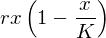

In [3]:
malthusian = r*x*(1-x/K)
malthusian

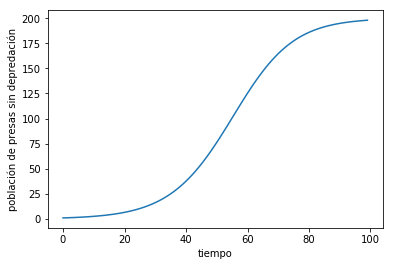

In [4]:
F = lambdify((x, r, K), malthusian)
pop = np.zeros(100)

# población inicial
pop[0] = 1
reproduccion = 0.1
capacidad = 200

# sumamos población en cada t
for t in range(99):
    pop[t+1] = pop[t] + F(pop[t], 
                          reproduccion,
                          capacidad)
    
plt.xlabel("tiempo")
plt.ylabel("población de presas sin depredación")
fig = plt.plot(pop)

## Tasa de cambio de la población de depredadores
Si se asume que la tasa de muertes del depredador es lineal y su densidad no es tal que se interfieran entre sí para cazar, entonces sólo la cantidad de presas limita la población de depredadores. 

$$\dot{x}=f(x)-y\phi(x)$$

$$\dot{y}=-ey+ky\phi(x)$$

$\phi(x)$ es la cantidad de presas atrapadas por depredador por unidad de tiempo, en función de la densidad de presas.

### Tasa de depredación según Holling

Lo esencial es que la tasa de depredación esté en función sólo de la densidad de presas. [Este artículo](https://math.la.asu.edu/~halsmith/Rosenzweig.pdf) discute la creación de tal función considerando el promedio de presas atrapadas a lo largo de un lapso extendido. El argumento $a$ modela el tiempo que le toma al depredador encontrar una presa, mientras que $b$ modela cuánto tiempo le toma atraparla, comérsela, digerirla, dormir la siesta, y empezar a acechar nuevamente.

$$\phi(x)=\frac{ax}{1+bx}$$

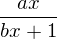

In [5]:
a, b = symbols('a b')
phi_holling = a*x / (1 + b*x)
phi_holling

In [6]:
# convertimos los símbolos de phi_holling en función ejecutable
phi_holling = lambdify((x, a, b), phi_holling)

Con un tiempo para encontrar presa de 20 unidades y un tiempo para consumirlas de 9 encontramos una curva parecida a la del [artículo de Hal L Smith](https://math.la.asu.edu/~halsmith/Rosenzweig.pdf).

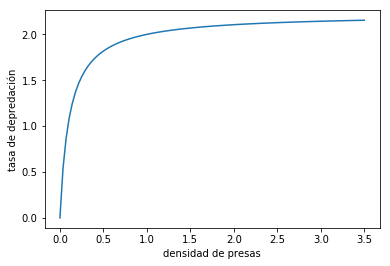

In [7]:
t_encontrar = 20
t_consumir = 9

presas = np.linspace(0, 3.5, 100)

# computamos depredaciones para un rango de densidades de presas
depredaciones = [phi_holling(n, 
                             t_encontrar,
                             t_consumir) 
                 for n in presas]

plt.xlabel("densidad de presas")
plt.ylabel("tasa de depredación")
fig = plt.plot(presas, depredaciones)

## Otra tasa de depredación

Una curva parecida a la de Holling se obtiene "saturando" de presas el área que ocupa un depredador.

$$\phi(x)=x^{\frac{1}{k}}+\left(1-\frac{1}{k}\right)$$

Donde $k$ representa la saturación.

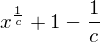

In [200]:
c = symbols('c')
phi_garcia = x**(1/c)+(1-1/c)
phi_garcia

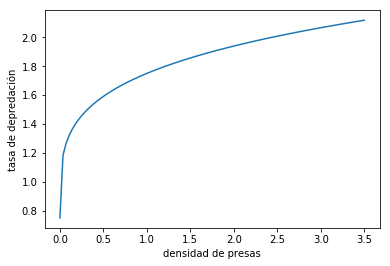

In [201]:
saturacion = 4
phi_garcia = lambdify((x, c), phi_garcia)
presas = np.linspace(0, 3.5, 100)
depredaciones = [phi_garcia(n, saturacion) for n in presas]
plt.xlabel("densidad de presas")
plt.ylabel("tasa de depredación")
fig = plt.plot(presas, depredaciones)

## Interacción de ambas poblaciones

Sustituyendo $f(x)$ por la dinámica malthusiana y $\phi(x)$ por el modello de Holling, el sistema de ecuaciones toma esta forma:

$$\dot{x}=rx\left(1-\frac{x}{K}\right)-y\frac{ax}{1+bx}$$

$$\dot{y}=-ey+ky\frac{ax}{1+bx}$$


In [212]:
# coeficientes de la presa
r = 0.1  # tasa de reproducción, eficiencia de recursos
K = 100  # capacidad de carga

# coeficientes del depredador
#a = 2  # tiempo para encontrar presas
#b = 1   # tiempo para consumirlas
e = 0.09  # tasa de mortalidad
c = 3  # saturación

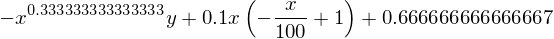

In [213]:
f = r*x*(1-x/K) - y * x**(1/c)+(1-1/c)
f

In [214]:
g = -e*y + (k * y) * x**(1/c)+(1-1/c)
g

### Equilibrios

In [215]:
M = solve(f, y)[0]
solve(M.subs({x: solve(g, x)}))

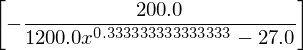

In [216]:
solve(g, y)

### Jacobiana

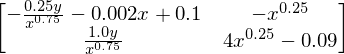

In [192]:
J = symbols("J")

J = Matrix([[diff(f, x), diff(f, y)], 
            [diff(g, x), diff(g, y)]])
J

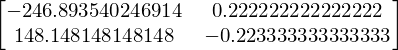

In [158]:
J = J.subs({x: -0.1, y:100})
J

In [159]:
J.det(), J.trace()

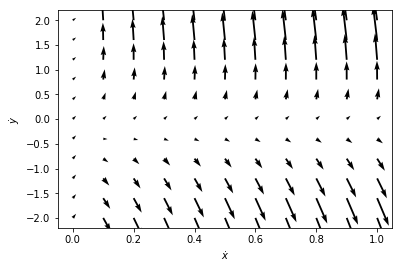

In [226]:
i, j = np.meshgrid(np.linspace(0, 1, 11),
                   np.linspace(-2, 2, 11))

F = lambdify((x,y), f)
G = lambdify((x,y), g)

u = F(i, j)
v = G(i, j)

plt.xlabel("$\dot{x}$")
plt.ylabel("$\dot{y}$")

plt.quiver(i, j, u, v)
